In [ ]:
# !pip install mysql-connector-python
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_db_connection():
    try:
        db = mysql.connector.connect(
            host="localhost",
            user="root",
            password="*******", #stored in a seperate file
            database="hrdb",
            use_pure=True
        )
        print("Connection successful")
        return db
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

def sql_script(query):
    mycursor.execute(query)
    result = mycursor.fetchall()
    column_names = [i[0] for i in mycursor.description]
    df = pd.DataFrame(result, columns=column_names)

    return df

db = get_db_connection()
mycursor = db.cursor()

table1 = sql_script("SELECT * FROM table1")
table2 = sql_script("SELECT * FROM table2")
attrition_data = table1.merge(table2, on="EmployeeNumber", how="left")
print("Database imported to DataFrame")

Connection successful
Database imported to DataFrame


Overall Company Attrition Percentage: 16.12%


C:\Users\roeer\AppData\Local\Temp\ipykernel_21228\2159313899.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=attrition_percentage, x='Department', y='Attrition_Percentage', palette='viridis')


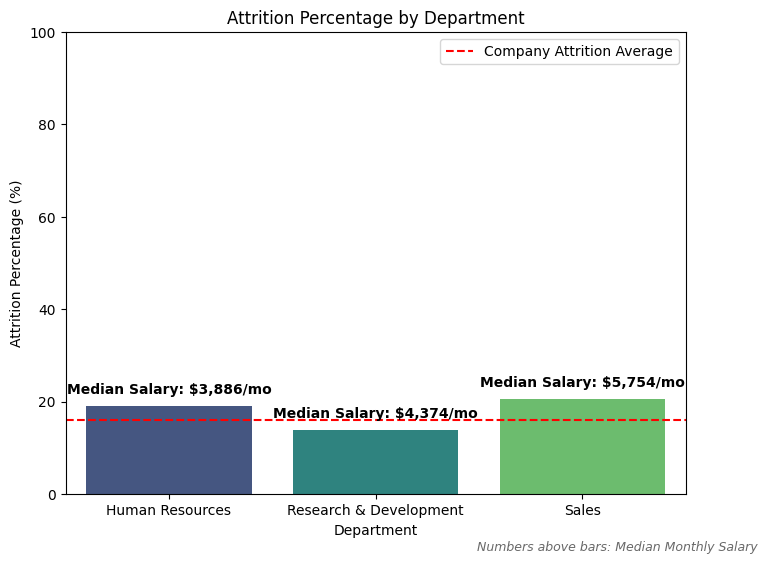

In [2]:
# Calculate overall attrition percentage for the entire company
if attrition_data['Attrition'].dtype == object:
    total_attrition = (attrition_data['Attrition'] == 'Yes').sum()
else:
    total_attrition = attrition_data['Attrition'].sum()
total_employees = len(attrition_data)
overall_attrition_percentage = (total_attrition / total_employees) * 100

print(f"Overall Company Attrition Percentage: {overall_attrition_percentage:.2f}%")

# Calculate attrition percentage for each department
if attrition_data['Attrition'].dtype == object:
    attrition_percentage = attrition_data.groupby('Department')['Attrition'].apply(lambda x: (x == 'Yes').mean() * 100).reset_index()
else:
    attrition_percentage = attrition_data.groupby('Department')['Attrition'].mean().mul(100).reset_index()
attrition_percentage.columns = ['Department', 'Attrition_Percentage']

# Calculate median salary (MonthlyIncome) for each department, matching order to attrition_percentage
median_salary_by_dept = attrition_data.groupby('Department')['MonthlyIncome'].median().reindex(attrition_percentage['Department']).values

# Plot barplot and add median salary labels above each column
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=attrition_percentage, x='Department', y='Attrition_Percentage', palette='viridis')
plt.axhline(overall_attrition_percentage, color='red', linestyle='--', label='Company Attrition Average')
plt.title('Attrition Percentage by Department')
plt.ylabel('Attrition Percentage (%)')
plt.xlabel('Department')
plt.ylim(0, 100)
plt.legend()

# Add median salary labels above each bar, indicating it's the median monthly salary
for i, p in enumerate(ax.patches):
    median_salary = median_salary_by_dept[i]
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(
        x, y + 2,
        f"Median Salary: ${median_salary:,.0f}/mo",
        ha='center', va='bottom', fontsize=10, color='black', fontweight='bold'
    )

# Add a note to the plot to clarify the salary annotation
plt.gcf().text(
    0.99, 0.01,
    "Numbers above bars: Median Monthly Salary",
    fontsize=9, color='dimgray', ha='right', va='bottom', style='italic'
)

plt.show()


In [3]:
# Print Job Satisfaction distribution by Attrition for each department
departments = attrition_data['Department'].unique()

for dept in departments:
    dept_data = attrition_data[attrition_data['Department'] == dept]
    if 'Attrition' in dept_data.columns and 'JobSatisfaction' in dept_data.columns:
        job_sat_dist = pd.crosstab(
            dept_data['JobSatisfaction'],
            dept_data['Attrition'],
            normalize='index'  # normalize across rows
        ).mul(100).round(2)
        print(f"Job Satisfaction Distribution in {dept} Department (by Attrition):")
        print(job_sat_dist)
        print("\n" + "-"*50 + "\n")
    else:
        print(f"Required columns 'Attrition' and/or 'JobSatisfaction' not found in {dept} data.")


Job Satisfaction Distribution in Sales Department (by Attrition):
Attrition           No    Yes
JobSatisfaction              
1                73.26  26.74
2                76.74  23.26
3                78.74  21.26
4                85.03  14.97

--------------------------------------------------

Job Satisfaction Distribution in Research & Development Department (by Attrition):
Attrition           No    Yes
JobSatisfaction              
1                80.21  19.79
2                86.21  13.79
3                85.67  14.33
4                90.51   9.49

--------------------------------------------------

Job Satisfaction Distribution in Human Resources Department (by Attrition):
Attrition           No    Yes
JobSatisfaction              
1                54.55  45.45
2                90.00  10.00
3                80.00  20.00
4                88.24  11.76

--------------------------------------------------



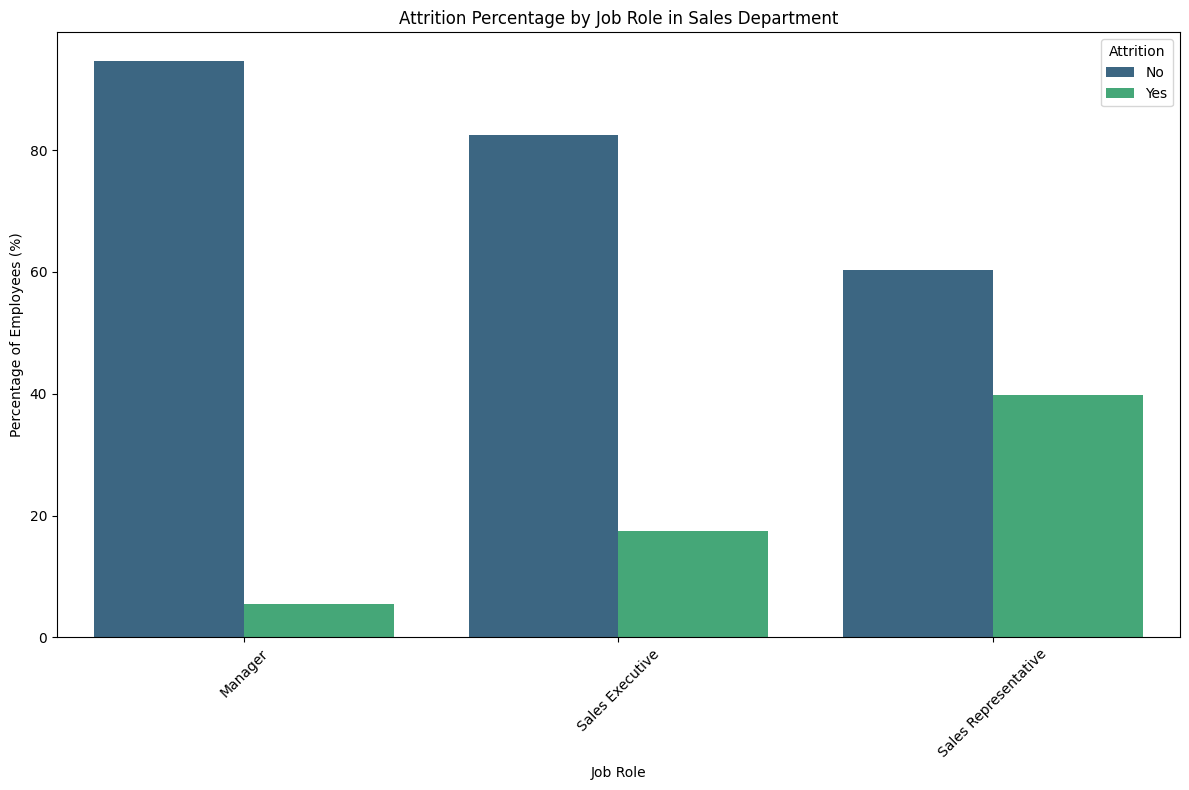

In [4]:
# Show attrition percentage across job roles in the Sales department, and add mean monthly rate for each bar

plt.figure(figsize=(12, 8))
sales_attrition = attrition_data[attrition_data['Department'] == 'Sales']

# Calculate percentage of attrition (Yes/No) within each JobRole
attrition_counts = (
    sales_attrition.groupby(['JobRole', 'Attrition'])
    .size()
    .reset_index(name='Count')
)
# Get total per JobRole
total_per_jobrole = attrition_counts.groupby('JobRole')['Count'].transform('sum')
attrition_counts['Percentage'] = (attrition_counts['Count'] / total_per_jobrole) * 100

# Calculate mean MonthlyRate for each (JobRole, Attrition) group
mean_monthlyrate = (
    sales_attrition.groupby(['JobRole', 'Attrition'])['MonthlyRate']
    .mean()
    .reset_index(name='MeanMonthlyRate')
)

# Merge mean monthly rate into attrition_counts
attrition_counts = attrition_counts.merge(mean_monthlyrate, on=['JobRole', 'Attrition'])

ax = sns.barplot(
    data=attrition_counts,
    x='JobRole',
    y='Percentage',
    hue='Attrition',
    palette='viridis'
)
plt.title('Attrition Percentage by Job Role in Sales Department')
plt.xlabel('Job Role')
plt.ylabel('Percentage of Employees (%)')
plt.xticks(rotation=45)
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()


C:\Users\roeer\AppData\Local\Temp\ipykernel_21228\3980564983.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_reps['YearsAtCompanyGroup'] = pd.cut(sales_reps['YearsAtCompany'], bins=bins, labels=labels, right=False)
C:\Users\roeer\AppData\Local\Temp\ipykernel_21228\3980564983.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_reps.groupby('YearsAtCompanyGroup')['Attrition']


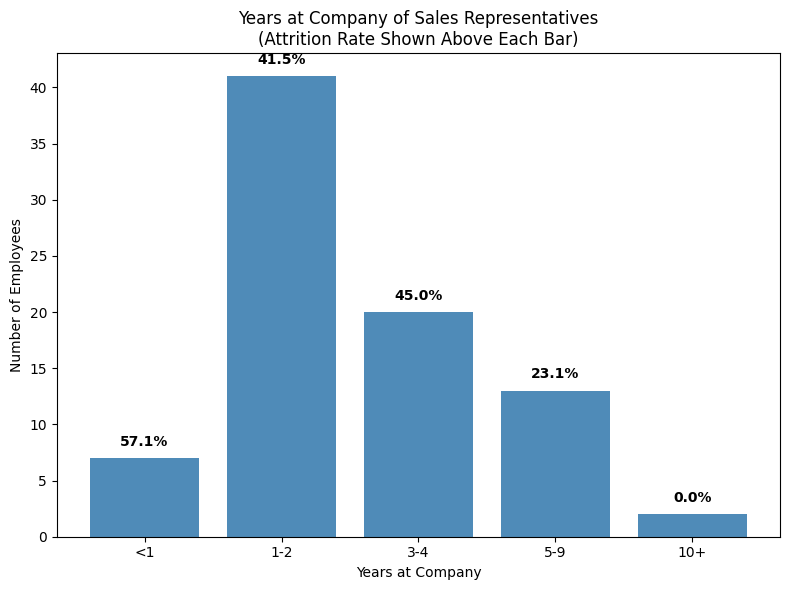

In [5]:
# Show Years at Company distribution for all Sales Representatives, as a bar chart with attrition rates as labels

plt.figure(figsize=(8, 6))
# Filter for all Sales Representatives
sales_reps = attrition_data[attrition_data['JobRole'] == 'Sales Representative']

# Bin YearsAtCompany into categories for better visualization
bins = [0, 1, 3, 5, 10, sales_reps['YearsAtCompany'].max() + 1]
labels = ['<1', '1-2', '3-4', '5-9', '10+']
# Ensure bins are strictly increasing
bins = sorted(set(bins))
sales_reps['YearsAtCompanyGroup'] = pd.cut(sales_reps['YearsAtCompany'], bins=bins, labels=labels, right=False)

# Count of each YearsAtCompany group
years_counts = sales_reps['YearsAtCompanyGroup'].value_counts().sort_index()

# Calculate attrition rate for each YearsAtCompany group
attrition_rates = (
    sales_reps.groupby('YearsAtCompanyGroup')['Attrition']
    .apply(lambda x: (x == 'Yes').mean() * 100)
    .sort_index()
)

# Create a bar chart with all bars in the same color
bar_color = '#4F8BB8'  # Example: a blue color, can be changed as desired
ax = plt.bar(years_counts.index.astype(str), years_counts.values, color=bar_color)

# Add attrition rate labels above each bar
for i, (count, label) in enumerate(zip(years_counts.values, years_counts.index)):
    rate = attrition_rates.get(label, None)
    if rate is not None:
        plt.text(
            i, count + max(years_counts.values) * 0.02,
            f"{rate:.1f}%", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
        )

plt.title('Years at Company of Sales Representatives\n(Attrition Rate Shown Above Each Bar)')
plt.xlabel('Years at Company')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()


C:\Users\roeer\AppData\Local\Temp\ipykernel_21228\2375681439.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


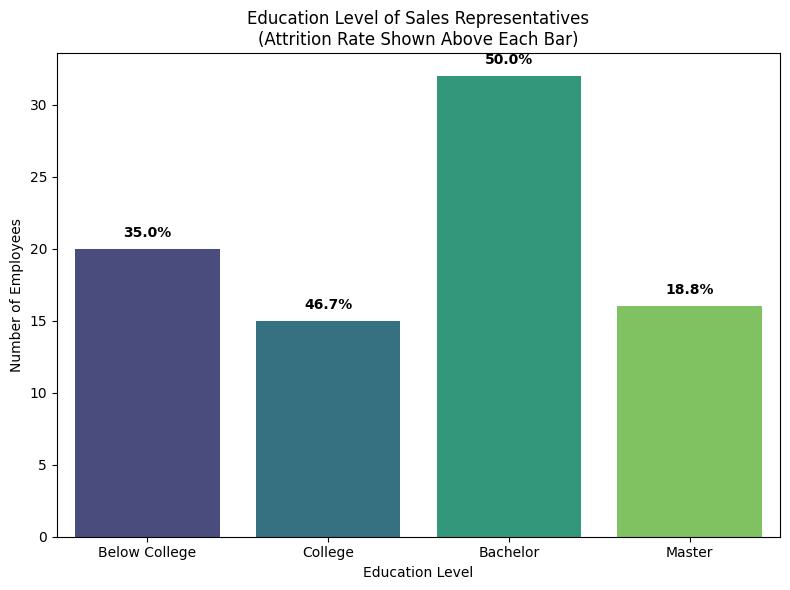

In [6]:
# Show education level distribution for all Sales Representatives, with attrition rates as labels

plt.figure(figsize=(8, 6))
# Filter for all Sales Representatives
sales_reps = attrition_data[attrition_data['JobRole'] == 'Sales Representative']

# Count of each education level
education_counts = sales_reps['Education'].value_counts().sort_index()

# Map education codes to labels if available
education_labels = {
    1: 'Below College',
    2: 'College',
    3: 'Bachelor',
    4: 'Master',
    5: 'Doctor'
}
education_counts.index = education_counts.index.map(lambda x: education_labels.get(x, str(x)))

# Calculate attrition rate for each education level
attrition_rates = (
    sales_reps.groupby('Education')['Attrition']
    .apply(lambda x: (x == 'Yes').mean() * 100)
    .sort_index()
)
# Map education codes to labels for attrition rates
attrition_rates.index = attrition_rates.index.map(lambda x: education_labels.get(x, str(x)))

ax = sns.barplot(
    x=education_counts.index,
    y=education_counts.values,
    palette='viridis'
)

# Add attrition rate labels above each bar
for i, (count, label) in enumerate(zip(education_counts.values, education_counts.index)):
    rate = attrition_rates.get(label, None)
    if rate is not None:
        ax.text(
            i, count + max(education_counts.values) * 0.02,
            f"{rate:.1f}%", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
        )

plt.title('Education Level of Sales Representatives\n(Attrition Rate Shown Above Each Bar)')
plt.xlabel('Education Level')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()


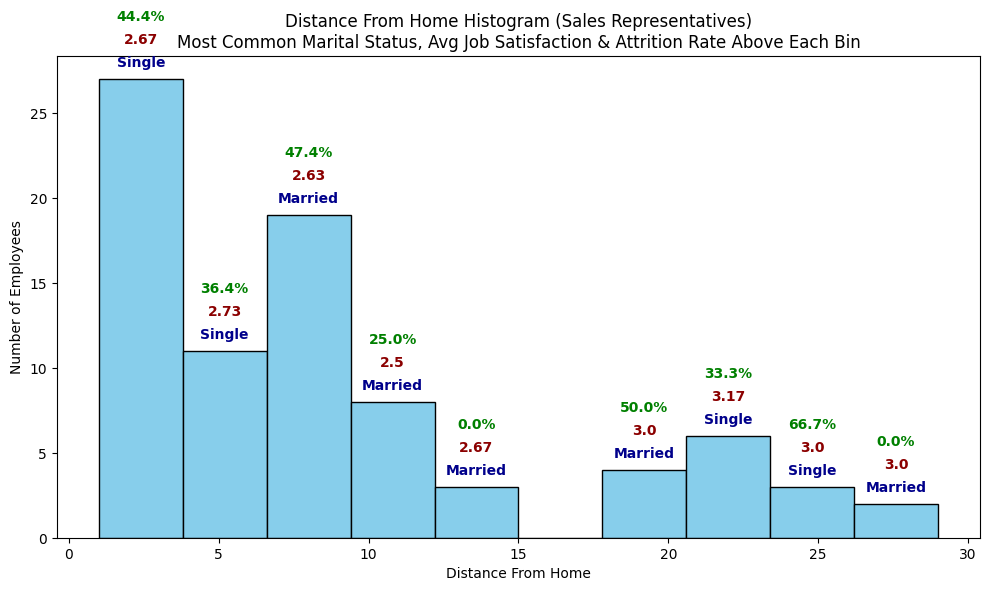

In [7]:
# adjust the graph to show only when the employees have a sales representative job role. keep this prompt as a comment on the top of the code

# Filter data for employees in the Sales department with JobRole 'Sales Representative'
sales_rep_data = attrition_data[
    (attrition_data['Department'] == 'Sales') & 
    (attrition_data['JobRole'] == 'Sales Representative')
]

# Set number of bins and compute bin edges
num_bins = 10
bin_edges = np.histogram_bin_edges(sales_rep_data['DistanceFromHome'], bins=num_bins)
bin_indices = np.digitize(sales_rep_data['DistanceFromHome'], bin_edges, right=False)

# Helper to compute a statistic or return "N/A"
def bin_stat(df, col, func, na="N/A"):
    if not df.empty and col in df:
        val = func(df[col])
        return val if val is not None else na
    return na

# Compute stats for each bin
most_common_marital_status = [
    bin_stat(sales_rep_data[bin_indices == i], 'MaritalStatus', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    for i in range(1, len(bin_edges))
]
avg_job_satisfaction = [
    bin_stat(sales_rep_data[bin_indices == i], 'JobSatisfaction', lambda x: round(x.mean(), 2) if not np.isnan(x.mean()) else None)
    for i in range(1, len(bin_edges))
]
attrition_rate = [
    bin_stat(sales_rep_data[bin_indices == i], 'Attrition', lambda x: f"{100 * (x == 'Yes').sum() / len(x):.1f}%" if len(x) else None)
    for i in range(1, len(bin_edges))
]

# Create histogram plot
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(
    sales_rep_data['DistanceFromHome'],
    bins=bin_edges,
    color='skyblue',
    edgecolor='black'
)

# Annotate each bin with stats
for i, patch in enumerate(patches):
    bin_center = patch.get_x() + patch.get_width() / 2
    height = patch.get_height()
    y_offset = max(counts) * 0.02
    for val, color in zip(
        [most_common_marital_status[i], avg_job_satisfaction[i], attrition_rate[i]],
        ['darkblue', 'darkred', 'green']
    ):
        if val != "N/A":
            plt.text(
                bin_center, height + y_offset, f"{val}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color=color
            )
            y_offset += max(counts) * 0.05

# Set plot title and axis labels
plt.title('Distance From Home Histogram (Sales Representatives)\nMost Common Marital Status, Avg Job Satisfaction & Attrition Rate Above Each Bin')
plt.xlabel('Distance From Home')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()